The intent of this notebook is to do Lane Detection on the provided Challenge Video.


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os

Lets try the pipeline on a single frame of the video.

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


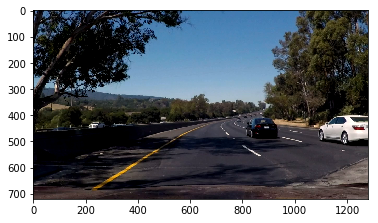

In [3]:
clip3 = VideoFileClip('test_videos/challenge.mp4')
one_frame = clip3.get_frame(6)
#Save the output image in the output directory
plt.imsave("test_images_output/one_frame", one_frame) 
#printing out some stats and plotting
print('This image is:', type(one_frame), 'with dimensions:', one_frame.shape)
plt.imshow(one_frame)

# Helper Functions

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=16):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #Variables to accumulate the Left and Right slopes
    m_left = 0
    m_right = 0
    #Variables to accumulate the Left and Right intercepts
    c_left = 0
    c_right = 0
    #Variables to count the number of line segments with positive (leftlane) and negative (rightlane) slope
    left_num = 0
    right_num = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1==x2 or y1==y2:
                break
            else:
                m = (y1-y2)/(x1-x2)
                c = y1 - m*x1
                if m > 0.2:
                    m_left += m
                    left_num += 1
                    c_left += c
                elif m < -0.2:
                    m_right += m
                    right_num += 1
                    c_right += c
    #Averaging Left and Right slopes & intercepts
    if left_num == 0:
        ml = 1
        cl = 0
    else:
        ml = m_left/left_num
        cl = c_left/left_num
    if right_num == 0:
        mr = 1
        cr = 0
    else:
        mr = m_right/right_num
        cr = c_right/right_num
    #Finding point of intersection of lane lines with horizontal edges of region of interest
    y2 = img.shape[0]
    y1 = int(img.shape[0]*.63)
    x2l = int((y2-cl)/ml)
    x1l = int((y1-cl)/ml)
    x2r = int((y2-cr)/mr)
    x1r = int((y1-cr)/mr)
    img_l  = cv2.line(img, (x1l, y1), (x2l, y2), color, thickness)
    img_lr = cv2.line(img_l, (x1r, y1), (x2r, y2), color, thickness)
    return img_lr

def draw_dotted_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

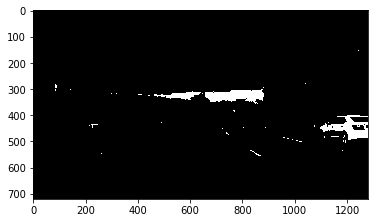

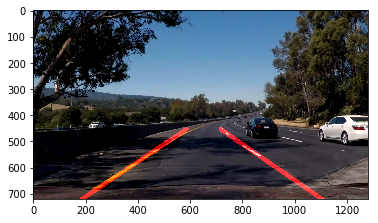

In [10]:
# Pipeline to detect and draw lane lines 

def process_image(img):
    #Pipe1: Convert color image to grayscale
    #gray_img = grayscale(img)
    #eqhist_gray_frame = cv2.equalizeHist(gray_img)
    #thresheld_img = cv2.adaptiveThreshold(eqhist_gray_frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([30,255,255])
    yellow_mask = np.zeros_like(hsv)
    yellow_mask =cv2.inRange(hsv, lower_yellow, upper_yellow)
    lower_white = np.array([0,0,205])
    upper_white = np.array([255,50,255])
    white_mask = np.zeros_like(hsv)
    white_mask =cv2.inRange(hsv, lower_white, upper_white)
    mask = np.zeros_like(hsv)
    yw_mask = cv2.bitwise_or(yellow_mask, white_mask)
    #Pipe2: Detect edges using Canny Edge detection
    canny_low_threshold = 100
    canny_high_threshold = 200
    edges_img = canny(yw_mask, canny_low_threshold, canny_high_threshold)
    #Pipe3: Apply Gaussian blur to smoothen the edges
    gaus_kernel_size = 3
    fine_edges_img = gaussian_blur(edges_img, gaus_kernel_size)
    #Pipe4: Select the region of interest - Region which has road lanes
    vertices = np.array([[(int(img.shape[1]*0.16),img.shape[0]), (int(img.shape[1]*0.42),int(img.shape[0]*0.63)), (int(img.shape[1]*0.6),int(img.shape[0]*0.63)), (int(img.shape[1]*0.92),img.shape[0])]], dtype=np.int32)
    masked_edge_img = region_of_interest(fine_edges_img, vertices)
    #Pipe5&6: Use Hough Transform to draw lines 
    hough_rho = 1
    hough_theta = np.pi/180
    hough_threshold = 30
    hough_min_line_len = 100
    hough_max_line_gap = 160
    hough_line_img = hough_lines(masked_edge_img, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap)
    #Pipe6: Overlay the lines on the main image
    final_img = weighted_img(hough_line_img, img, α=1., β=0.8, λ=0.)
    return final_img


#gray_frame = grayscale(one_frame)
gray_frame = cv2.cvtColor(one_frame, cv2.COLOR_RGB2HSV)
lower_yellow = np.array([20,100,100])
upper_yellow = np.array([30,255,255])
yellow_mask =cv2.inRange(gray_frame, lower_yellow, upper_yellow)
lower_white = np.array([0,0,195], dtype=np.uint8)
upper_white = np.array([255,60,255], dtype=np.uint8)
white_mask =cv2.inRange(gray_frame, lower_white, upper_white)
mask = np.zeros_like(gray_frame)
yw_mask = cv2.bitwise_or(yellow_mask, white_mask)
#new_frame = cv2.bitwise_and(gray_frame,yw_mask)
#eqhist_gray_frame = cv2.equalizeHist(gray_frame)
#thresheld_img = cv2.adaptiveThreshold(eqhist_gray_frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
#Pipe2: Detect edges using Canny Edge detection
canny_low_threshold = 100
canny_high_threshold = 200
eqhist_edges_img = canny(yw_mask, canny_low_threshold, canny_high_threshold)
#Pipe3: Apply Gaussian blur to smoothen the edges
gaus_kernel_size = 3
eq_fine_edges_img = gaussian_blur(eqhist_edges_img, gaus_kernel_size)
#Pipe4: Select the region of interest - Region which has road lanes
vertices = np.array([[(int(one_frame.shape[1]*0.16),one_frame.shape[0]), (int(one_frame.shape[1]*0.42),int(one_frame.shape[0]*0.63)), (int(one_frame.shape[1]*0.6),int(one_frame.shape[0]*0.63)), (int(one_frame.shape[1]*0.92),one_frame.shape[0])]], dtype=np.int32)
masked_edge_img = region_of_interest(eq_fine_edges_img, vertices)
#Pipe5&6: Use Hough Transform to draw lines 
hough_rho = 1
hough_theta = np.pi/180
hough_threshold = 30
hough_min_line_len = 100
hough_max_line_gap = 160
hough_line_img = hough_lines(masked_edge_img, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap)
#Pipe6: Overlay the lines on the main image
final_img = weighted_img(hough_line_img, one_frame, α=1., β=0.8, λ=0.)

plt.imshow(white_mask, cmap='gray')
plt.figure()
plt.imshow(final_img)


In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:20<00:00, 12.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 23.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))